In [1]:
import numpy as np
import seaborn as sns; sns.set()

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')

x_test = x_test.astype('float64')
y_test = y_test.astype('float64')


In [4]:
def predict(image):
    layer_0 = image.reshape(1, PIXELS_PER_IMAGE)/255
    layer_1 = relu(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)
    
    print(np.argmax(layer_2))

    
def confusion_matrix(y_pred, y_true):
    unique_values = list(set(y_true) | set(y_pred))
    mtrx = np.zeros((len(unique_values), len(unique_values)))
    for y_p, y_t in zip(y_pred, y_true):
        mtrx[unique_values.index(y_p)][unique_values.index(y_t)] += 1
    return mtrx, unique_values


In [5]:
PIXELS_PER_IMAGE = 28*28
UNIQUE_LABELS = np.unique(y_test)

PIXELS_PER_IMAGE, UNIQUE_LABELS

(784, array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

In [6]:
def one_hot_encoder(array):
    """
    Encodes vector into the one hot matrix.
    """
    unique_values = np.unique(array)
    one_hot_labels = np.zeros((len(array), len(unique_values)))
    for i, el in enumerate(array):
        one_hot_labels[i][np.where(unique_values==el)[0]] = 1
    return one_hot_labels


def img_label_generator(images, labels, batch_size=1):
    """
    Yields pair of (data, label) with given batch size
    """
    count_of_images = len(images)
    assert count_of_images == len(labels)
    for  i in range(int(count_of_images//batch_size)):
        yield images[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size]

        
def relu(x):
    return (x >= 0) * x


def relu2deriv(output):
    return output >= 0


def tanh(x):
    return np.tanh(x)


def tanh2deriv(output):
    return 1 - (output ** 2)


def softmax(x):
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)


## Data prepearing

In [7]:
images = x_train[:1000].reshape(1000, PIXELS_PER_IMAGE)/255
labels = one_hot_encoder(y_train[:1000])

test_images = x_test.reshape(len(x_test), PIXELS_PER_IMAGE)/255
test_labels = one_hot_encoder(y_test)

## Model hyperparameters

In [11]:
alpha = 0.02
iterations = 200
hidden_size = 40
batch_size = 50

### Training process

In [12]:
%%time

np.random.seed(1)

weights_0_1 = 0.02 * np.random.random((PIXELS_PER_IMAGE, hidden_size)) - 0.01
weights_1_2 = 0.2 * np.random.random((hidden_size, len(UNIQUE_LABELS)))

for iteration in range(iterations):
    err, correct_cnt = .0, .0
    
    for img_chunk, labels_chunk in img_label_generator(images, labels, batch_size=batch_size):
        
        layer_0 = img_chunk
        
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape).astype('float64')
        layer_1 *= dropout_mask * 2
        
        layer_2 = softmax(np.dot(layer_1, weights_1_2))

        err += np.sum((labels_chunk - layer_2) ** 2)  # squared error
        for layer_val, label in img_label_generator(layer_2, labels_chunk):
            correct_cnt += int(np.argmax(layer_val)) == np.argmax(label)

            layer_2_delta = (labels_chunk - layer_2)/(batch_size * layer_2.shape[0])
            
            #Back propagation
            layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)
            layer_1_delta *= dropout_mask
            
            #Weights updating
            weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
            
    if iteration % 10 == 0:
        test_err, test_correct_cnt = 0, 0
        err = err/len(images)
        correct_cnt = correct_cnt/len(images)
        
        print(f"Iteration: {iteration} \nError: {err:.4f} Acc: {correct_cnt:.4f}")
        for img, label in img_label_generator(test_images, test_labels):
            layer_0 = img
            layer_1 = tanh(np.dot(layer_0, weights_0_1))
            layer_2 = softmax(np.dot(layer_1, weights_1_2))
            
            test_err += np.sum((label - layer_2) ** 2) / len(test_images)
            test_correct_cnt += np.argmax(label) == np.argmax(layer_2)
            test_acc = test_correct_cnt/len(test_images)

        print(f"Test-error: {test_err:.3f} Test-acc: {test_acc:.3f}\n")


Iteration: 0 
Error: 0.8978 Acc: 0.1740
Test-error: 0.895 Test-acc: 0.314

Iteration: 10 
Error: 0.7890 Acc: 0.6400
Test-error: 0.786 Test-acc: 0.625

Iteration: 20 
Error: 0.6096 Acc: 0.6920
Test-error: 0.614 Test-acc: 0.678

Iteration: 30 
Error: 0.4860 Acc: 0.7590
Test-error: 0.493 Test-acc: 0.737

Iteration: 40 
Error: 0.4031 Acc: 0.8050
Test-error: 0.413 Test-acc: 0.781

Iteration: 50 
Error: 0.3345 Acc: 0.8420
Test-error: 0.357 Test-acc: 0.809

Iteration: 60 
Error: 0.2947 Acc: 0.8600
Test-error: 0.317 Test-acc: 0.827

Iteration: 70 
Error: 0.2612 Acc: 0.8720
Test-error: 0.288 Test-acc: 0.837

Iteration: 80 
Error: 0.2287 Acc: 0.8870
Test-error: 0.267 Test-acc: 0.843

Iteration: 90 
Error: 0.2086 Acc: 0.9050
Test-error: 0.252 Test-acc: 0.847

Iteration: 100 
Error: 0.1938 Acc: 0.9060
Test-error: 0.238 Test-acc: 0.854

Iteration: 110 
Error: 0.1835 Acc: 0.9120
Test-error: 0.229 Test-acc: 0.855

Iteration: 120 
Error: 0.1675 Acc: 0.9180
Test-error: 0.224 Test-acc: 0.855

Iteration:

3

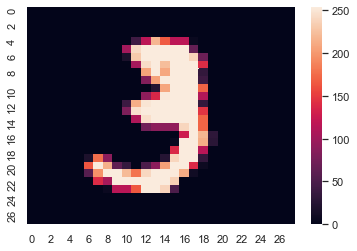

In [10]:
def predict(img):
    sns.heatmap(img)
    img = img.reshape(1, PIXELS_PER_IMAGE)
    layer_0 = img
    layer_1 = tanh(np.dot(layer_0, weights_0_1))
    layer_2 = softmax(np.dot(layer_1, weights_1_2))
    return np.argmax(layer_2)

predict(x_train[10])
    